In [1]:

import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp
from genpen.utils import Paper
from scipy import stats
import geopandas
from shapely.errors import TopologicalError
import functools
import vpype
from skimage import io
from pathlib import Path

from sklearn.preprocessing import minmax_scale
from skimage import feature
from skimage import exposure
from torch import Tensor
from torch import nn
from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk
from numpy.random import default_rng


from PIL import Image
import attr

import cv2
from rasterio import features
import rasterio
%load_ext autoreload
%autoreload 2

In [2]:
import pydiffvg as dg
import torch
import skimage
import numpy as np
from torchvision.transforms import functional as TF
from IPython import display
from copy import deepcopy
import fn
import torch.nn.functional as F


In [3]:

from genpen.diffvg import diffvg as gdg

In [4]:
# Use GPU if available
dg.set_use_gpu(torch.cuda.is_available())

In [5]:
from genpen.diffvg.diffvg import ParamHead, ShapeGroupMaker, ShapeMaker, LazySigmoid, CanvasNet, LazyRelu

In [6]:
def rescale(x, min_val, max_val):
    min_val = torch.tensor(min_val)
    max_val = torch.tensor(max_val)
    return x * (max_val - min_val) + min_val

In [7]:
class Reshape(nn.Module):
    
    def __init__(self, dims):
        super().__init__()
        self.dims = dims
        
    def forward(self, x):
        return x.view(self.dims)

In [8]:
class SigmoidParameter(nn.Module):
    
    def __init__(self, n_shapes, n_params):
        super().__init__()
        self.n_shapes = n_shapes
        self.n_params = n_params
        self.net = nn.Sequential(
            LazySigmoid(n_params*n_shapes),
            Reshape((n_shapes, n_params)),
        )
        
    def forward(self, x):
        return self.net(x)

In [9]:
def train(canvas_net, optim, loss_weights=None):
    
    shapes, shape_groups, tensors = canvas_net.forward()
    optim.zero_grad()
    losses = {}
    if loss_weights is None:
        loss_weights = {
            'big_rad_loss': 1,
            'overlap_loss': 1,
            'distance_loss': 1,
            'out_of_bounds_loss': 1,
            
        }
    overlap_buffer = 0
    shapes_tensors = tensors['shapes_tensors']
    # big rad 
    losses['big_rad_loss'] = shapes_tensors['radius'].exp().sum()

    # prevent overlap
    dists = torch.cdist(shapes_tensors['center'], shapes_tensors['center'])
    upper_dists = torch.triu(dists)
    nonzero_inds = torch.nonzero(upper_dists, as_tuple=True)
    dists[nonzero_inds]
    summed_rads = shapes_tensors['radius'].T + shapes_tensors['radius']
    edge_to_edge_dists = dists[nonzero_inds] - summed_rads[nonzero_inds] - overlap_buffer
    losses['overlap_loss'] = F.relu(-edge_to_edge_dists).pow(3).sum()
    losses['distance_loss'] = edge_to_edge_dists.pow(2).sum()
    scaled_losses = {key: loss*loss_weights[key] for key, loss in losses.items()}
    loss = sum(scaled_losses.values())

    loss.backward()
    optim.step()
    
    scaled_losses['loss'] = loss
    return losses, scaled_losses, shapes, shape_groups, tensors

In [10]:
def train_nima(canvas_net, optim, model_ft, canvas):
    
    
    
    
    optim.zero_grad()
    
    shapes, shape_groups, tensors = canvas_net.forward()
    img = canvas.render(shapes, shape_groups)

    # transform = transforms.Compose([
    #             transforms.Resize(224),
    #             transforms.CenterCrop(224),
    #         ])
    # img = transform(img)
    img = img.swapdims(1,3)
    # img = img.reshape(1,3,224,224)
    scores = model_ft(img)
    weighted_votes = torch.arange(10, dtype=torch.float, device=device) + 1
    loss = -torch.matmul(scores, weighted_votes)

    loss.backward()
    optim.step()
    
    
    return loss, shapes, shape_groups, tensors, img

In [18]:
from torchvision import datasets, models, transforms

# Number of classes in the dataset
num_classes = 10

# Weight Path
weight_path = '/home/naka/code/side/ML-Aesthetics-NIMA/weights/dense121_all.pt'

model_ft = models.densenet121(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Sequential(
    nn.Linear(num_ftrs,num_classes),
    nn.Softmax(1)
)   

# Send the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
# for param in model_ft.parameters():
#     param.requires_grad = False

In [25]:
n_shapes = 10
shape_param_head = ParamHead(nets={
    'center': SigmoidParameter(n_shapes, 2),
    'radius': SigmoidParameter(n_shapes, 1),
    'stroke_width': SigmoidParameter(n_shapes, 1),
})

param_transforms = {
    'center': lambda x: rescale(x, 10., 214.),
    'radius': lambda x: rescale(x, 1., 50.),
    'stroke_width': lambda x: rescale(x, 0.1, 1.),
}


shape_maker = ShapeMaker(
    shape_class=dg.Circle, 
    n_shapes=n_shapes,
    param_transforms=param_transforms,
    base_id=0,
    # init_params={
    #     'center': torch.rand(n_shapes, 2)/3,
    #     'radius': torch.rand(n_shapes, 1)/3,
    #     'stroke_width': torch.rand(n_shapes, 1)/3,
    # }
    )

shape_head = nn.Sequential(shape_param_head, shape_maker)

shape_groups_param_head = ParamHead(nets={
    'stroke_color': SigmoidParameter(1, 4),  # need to do some kind of reduction across shape dim
    'fill_color': SigmoidParameter(1, 4),
})
shape_groups_maker = ShapeGroupMaker(
    shape_ids=shape_maker.ids,
    param_transforms={
        'stroke_color': lambda x: torch.tensor([1., 1., 1., 1.]),
        'fill_color': lambda x: None
        }
    )
shape_groups_head = nn.Sequential(shape_groups_param_head, shape_groups_maker)

canvas_net = CanvasNet(
    backbone=nn.Sequential(
        nn.Linear(1, 128),
        nn.ReLU(),
        LazyRelu(128),
        LazyRelu(128),
        LazyRelu(128),
    ),
    shapes_head=shape_head,
    shape_groups_head=shape_groups_head,
)


/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [26]:
def init_weights(m, gain=4.):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=gain)
        m.bias.data.fill_(0.01)

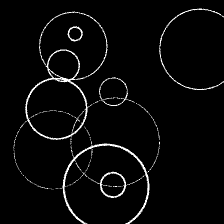

In [14]:
shapes, shape_groups, tensors = canvas_net.forward()
canvas_net.apply(init_weights);
shapes, shape_groups, tensors = canvas_net.forward()
canvas = gdg.Canvas(width=224, height=224)
canvas.render(shapes, shape_groups, as_pil=True)

In [15]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=1e-2)

In [19]:
loss, shapes, shape_groups, tensors, img = train_nima(canvas_net, optim, model_ft, canvas)
print(loss)
img


RuntimeError: Function RenderFunctionBackward returned an invalid gradient at index 1 - got [] but expected shape compatible with [1]

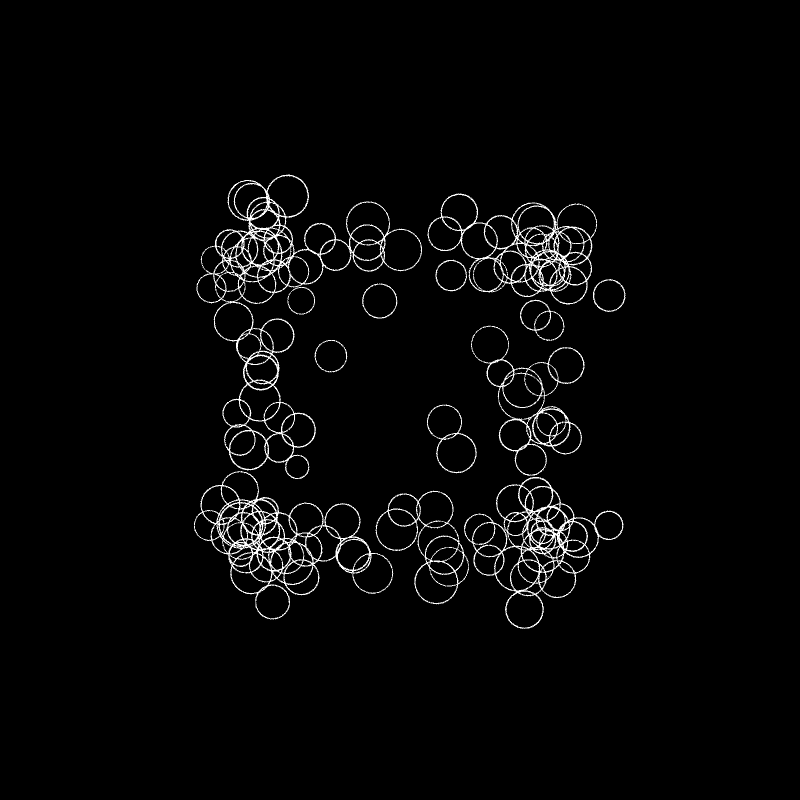

In [76]:
losses, scaled_losses, shapes, shape_groups, tensors = train(
        loss_weights = {
            'big_rad_loss': 1e-4,
            'overlap_loss': 1,
            'distance_loss': -1e1,
            'out_of_bounds_loss': 1e0, 
            },
        canvas_net=canvas_net,
        optim=optim,
    )
canvas.render(shapes, shape_groups, as_pil=True)

In [23]:
img.permute(0,3,1,2)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
       grad_fn=<PermuteBackward>)

In [24]:
optim.zero_grad()
    
shapes, shape_groups, tensors = canvas_net.forward()
img = canvas.render(shapes, shape_groups)

# transform = transforms.Compose([
#             transforms.Resize(224),
#             transforms.CenterCrop(224),
#         ])
# img = transform(img)
# img = img.swapdims(1,3)
# img = img.reshape(1,3,224,224)
img = img.permute(0,3,1,2)
scores = model_ft(img)
weighted_votes = torch.arange(10, dtype=torch.float, device=device) + 1
loss = -torch.matmul(scores, weighted_votes)

loss.backward()
optim.step()

[W accumulate_grad.h:185] Warning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [128, 992, 1, 1], strides() = [992, 1, 1, 1]
param.sizes() = [128, 992, 1, 1], strides() = [992, 1, 992, 992] (function operator())


RuntimeError: Function RenderFunctionBackward returned an invalid gradient at index 1 - got [] but expected shape compatible with [1]

In [166]:
img = canvas.render(shapes, shape_groups, as_pil=True)

transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
_img = transform(img).to(device)

with torch.no_grad():
    scores = model_ft(_img.view(1,3,224,224))
    weighted_votes = torch.arange(10, dtype=torch.float, device=device) + 1
    mean = torch.matmul(scores, weighted_votes)

In [17]:
img = canvas.render(shapes, shape_groups)

transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
        ])


In [21]:
img.swapdims(1,3)

TypeError: swapdims() takes 2 positional arguments but 3 were given

In [18]:
transform(img)

RuntimeError: CUDA out of memory. Tried to allocate 3.13 GiB (GPU 0; 7.79 GiB total capacity; 28.52 MiB already allocated; 2.92 GiB free; 48.00 MiB reserved in total by PyTorch)

In [ ]:

scores = model_ft(img.view(1,3,224,224))
weighted_votes = torch.arange(10, dtype=torch.float, device=device) + 1
mean = torch.matmul(scores, weighted_votes)

In [168]:
scores

tensor([[0.0978, 0.0573, 0.0992, 0.0732, 0.1403, 0.0353, 0.0705, 0.0756, 0.1146,
         0.2363]], device='cuda:0')

In [33]:
nft_id = fn.new_nft_id()

raster_videos_dir = Path('/home/naka/art/raster_videos')
nft_dir = raster_videos_dir.joinpath(nft_id)

if not nft_dir.exists():
    os.mkdir(nft_dir) 

saved 20220701-161945_445387-bbd12-d39635 to s3://algorithmic-ink/current_nft_id


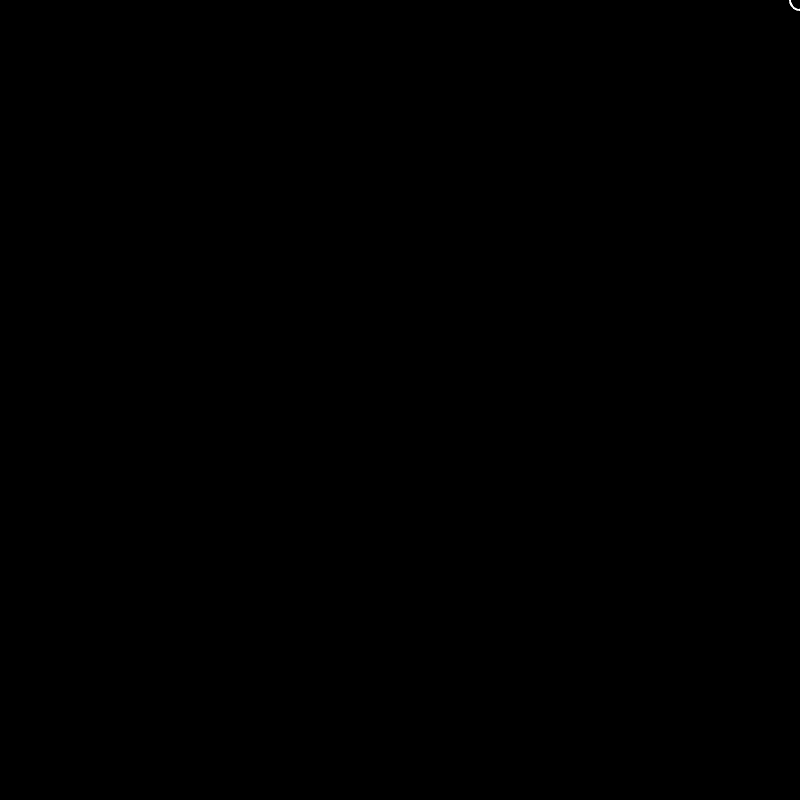

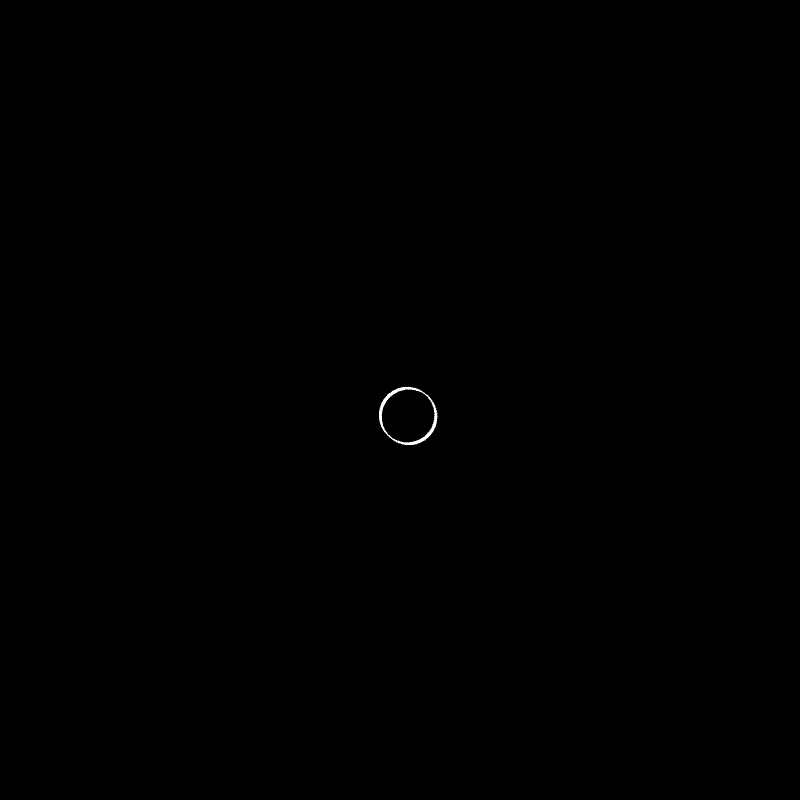

100%|██████████| 100/100 [00:00<00:00, 153.69it/s]

big_rad_loss 10701174210560.0
overlap_loss 7308312.0
distance_loss 133935.53125
loss 10701181550592.0


In [30]:
canvas = gdg.Canvas(width=800, height=800)
frame_counter = 0
display_freq = 10
save = False
for ii in tqdm(range(100)):
    losses, scaled_losses, shapes, shape_groups, tensors = train(
        loss_weights = {
            'big_rad_loss': 1,
            'overlap_loss': 1,
            'distance_loss': 1,
            'out_of_bounds_loss': 1e0, 
            },
        canvas_net=canvas_net,
        optim=optim,
    )
    if ii % display_freq == 0:
        
        display.clear_output(wait=True)
        img = canvas.render(shapes, shape_groups, as_pil=True)

        fp = nft_dir.joinpath(f'{frame_counter:04d}.png')
        img.save(fp)
        display.display(display.Image(fp))
            
        frame_counter += 1
        
for k,v in scaled_losses.items():
    print(k, float(v))

# img = render_circles(cc.to_circle_ps())
# to_pil(img)

In [2467]:
nft_dir

PosixPath('/home/naka/art/raster_videos/20220115-150952_169288-08f81-f7fd2a')

In [2563]:
filenames = sorted([fp.as_posix() for fp in nft_dir.glob('*.png')])

In [2564]:
import moviepy
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

In [2567]:
clipout = ImageSequenceClip(filenames, fps=30)
clipout.write_videofile(nft_dir.joinpath(f'{nft_id}.mp4').as_posix())

t:   0%|          | 0/701 [00:00<?, ?it/s, now=None]

Moviepy - Building video /home/naka/art/raster_videos/20220115-152135_807294-08f81-a0a461/20220115-152135_807294-08f81-a0a461.mp4.
Moviepy - Writing video /home/naka/art/raster_videos/20220115-152135_807294-08f81-a0a461/20220115-152135_807294-08f81-a0a461.mp4



Moviepy - Done !
Moviepy - video ready /home/naka/art/raster_videos/20220115-152135_807294-08f81-a0a461/20220115-152135_807294-08f81-a0a461.mp4


In [2387]:
len(filenames)

550

In [1817]:
x = model.get_net_output()
model.get_xs(x).shape

torch.Size([1, 10])

In [1818]:
model.radius_outputs(x)

tensor([0.0000, 0.0000, 0.0592, 0.0312, 0.0000, 0.0079, 0.0069, 0.0367, 0.0115,
        0.0093], grad_fn=<ReluBackward0>)

In [1565]:
n_circles = 100
init_rad_range = (0.001,1)
init_x_range = (CANVAS_WIDTH*0.1, CANVAS_WIDTH*0.9)
init_y_range = (CANVAS_HEIGHT*0.1, CANVAS_HEIGHT*0.9)
xmin, xmax = init_x_range
ymin, ymax = init_y_range

net = nn.Sequential(
    nn.Linear(0, n_circles),
    nn.ReLU(),
    nn.LazyLinear(n_circles),
    nn.ReLU(),
    nn.LazyLinear(n_circles),
    nn.ReLU(),
)

xs = torch.rand(n_circles, 2) * (xmax - xmin) + xmin
ys = torch.rand(n_circles, 2) * (ymax - ymin) + ymin

centers = torch.cat([xs, ys], axis=1)
radii = torch.rand(n_circles) * (init_rad_range[1] - init_rad_range[0]) + init_rad_range[0]
colors = torch.ones((n_circles,4))
stroke_widths = torch.ones((n_circles,1)) * 1

cc = CircleCollection(centers=centers, radii=radii, stroke_widths=stroke_widths, colors=colors)

/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/naka/anaconda3/envs/genpen/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [1563]:
n_circles = 100
init_rad_range = (0.001,1)
init_x_range = (CANVAS_WIDTH*0.1, CANVAS_WIDTH*0.9)
init_y_range = (CANVAS_HEIGHT*0.1, CANVAS_HEIGHT*0.9)
xmin, xmax = init_x_range
ymin, ymax = init_y_range

xs = np.interp(np.random.rand(n_circles), [0, 1], init_x_range)
ys = np.interp(np.random.rand(n_circles), [0, 1], init_y_range)
centers = [(x, y) for x, y in zip(xs, ys)]
radii = np.interp(stats.beta(a=1, b=3).rvs(n_circles), (0, 1), init_rad_range)
colors = np.ones((n_circles,4))
stroke_widths = np.ones((n_circles,1)) * 1

cc = CircleCollection.from_arrays(centers=centers, radii=radii, stroke_widths=stroke_widths, colors=colors)

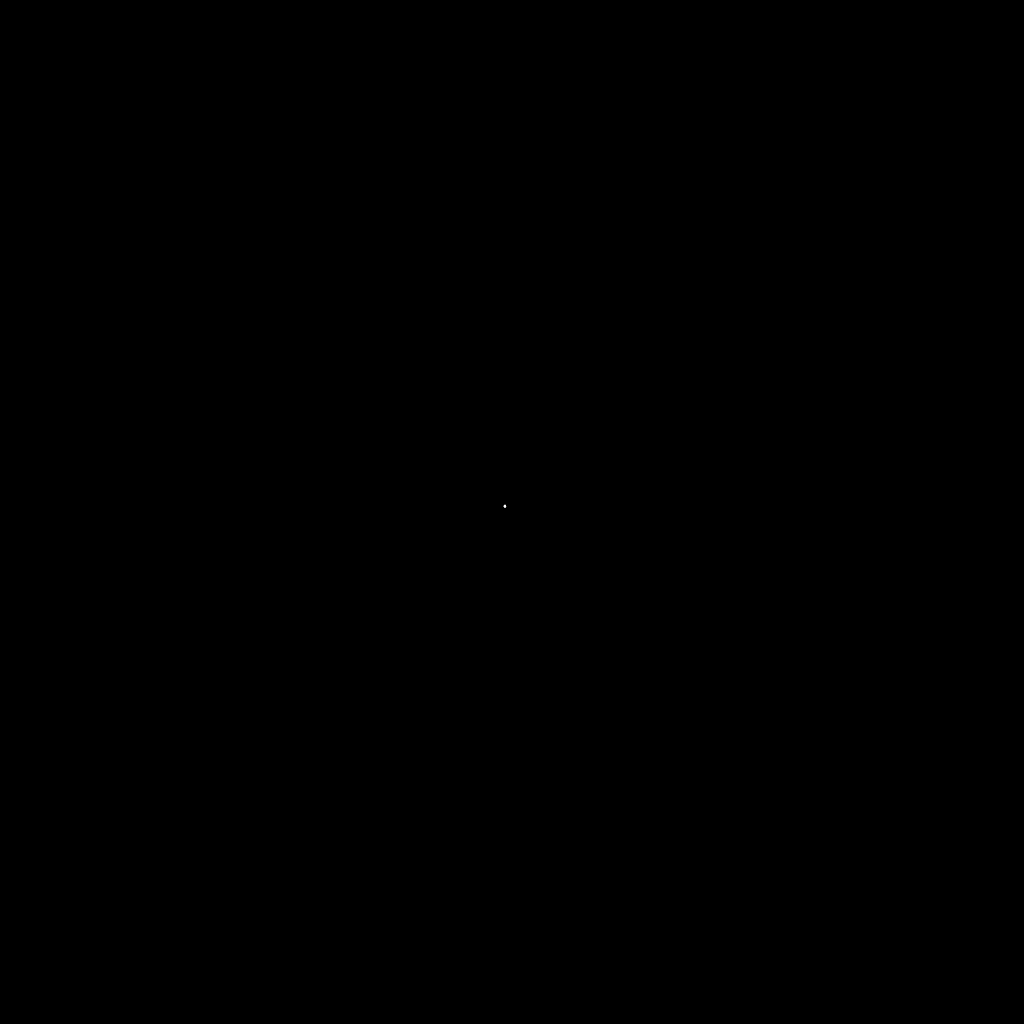

In [1612]:
img = render_circles(cc)
to_pil(img)


In [ ]:
quality_val = 100
now = fn.get_time()
filepath = nft_dir.joinpath(f'{nft_id}_{now}_0000.jpeg')
alpha_composite.convert('RGB').save(filepath, quality=quality_val)